# TPU를 사용하기 위한 설정

In [ ]:
# BERT는 colab TPU로 학습해야 시간이 덜 걸림

In [ ]:
# #  TPU초기 설정
# import tensorflow as tf
# import os

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)

# strategy = tf.distribute.TPUStrategy(resolver)

# 기본 구성

In [ ]:
pip install wordcloud

In [ ]:
pip install hanja # 한자 분류 모듈

     |████████████████████████████████| 286kB 6.9MB/s 
  Created wheel for coverage: filename=coverage-3.7.1-cp37-cp37m-linux_x86_64.whl size=129651 sha256=96e2dc877ef328918b4de29ad8e00091d775134972ac587a5f4376b308a9370e
  Stored in directory: /root/.cache/pip/wheels/68/58/66/f1fc9afad272df0df0fa38cdef34ee2d5d8d6a85f4eb5acab5
Successfully built coverage
ERROR: pytest-cov 2.12.1 has requirement coverage>=5.2.1, but you'll have coverage 3.7.1 which is incompatible.
ERROR: pytest-cov 2.12.1 has requirement pytest>=4.6, but you'll have pytest 3.6.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: coverage 5.5
    Uninstalling coverage-5.5:
      Successfully uninstalled coverage-5.5


In [ ]:
# !pip install transformers
# pip install transformers==3.5.0 # 오류뜰경우 3.5.0으로 다시 설치

In [ ]:
 !nvidia-smi 

Thu Jul  8 06:12:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# pip install kobart-transformers

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import KFold

from tqdm import tqdm

import hanja
from hanja import hangul
from nltk.corpus import stopwords # 불용어 처리를 위한 NLTK라이브러리의 stopwords이용

from transformers import BertTokenizer, TFBertModel,PreTrainedTokenizerFast, TFBartModel
from kobart_transformers import get_kobart_tokenizer, get_kobart_model

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences #tensorflow 전처리 모듈1
from tensorflow.keras.preprocessing.text import Tokenizer #tensorflow 전처리 모듈2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 그래프를 출력창에서 바로 볼 수 있게함
%matplotlib inline 


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/train_data.csv", error_bad_lines=False  )
test = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/test_data.csv",error_bad_lines=False)
submission = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/sample_submission.csv",error_bad_lines=False)
topic_dict = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/topic_dict.csv",error_bad_lines=False)

# BERT를 이용한 NEWS Topic 분류

### EDA

In [ ]:
train_length = train['title'].astype(str).apply(len)
train_length.max()

44

Text(0, 0.5, 'counts')

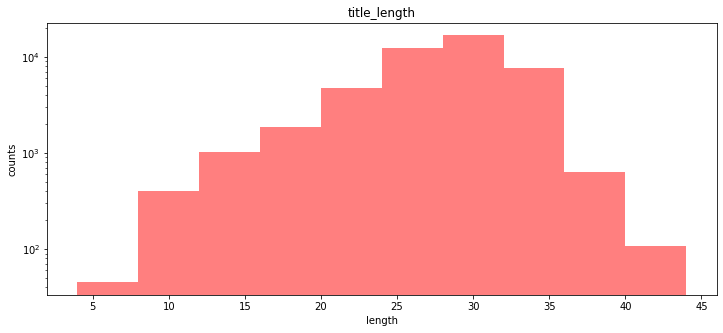

In [ ]:
plt.figure(figsize=(12,5)) # (가로, 세로) 형태의 tuple로 입력
plt.hist(train_length, alpha=0.5, color='r',label='word') # alpha 그래프 색상 투명도, label: 그래프 label
plt.yscale('log', nonposy='clip')
plt.title("title_length") #그래프 제목
plt.xlabel("length") # x축 label
plt.ylabel("counts") # x축 label

In [ ]:
 # MAX_LEN 설정시 확인
print('문장 길이 최댓값 : {}'.format(np.max(train_length))) # title길이 최대값
print('문장 길이 최소값 : {}'.format(np.min(train_length))) # title길이 최소값
print('문장 길이 평균값 : {:.2f}'.format(np.mean(train_length))) # title길이 평균값
print('문장 길이 표준편차 : {:.2f}'.format(np.std(train_length))) # title길이 표준편차
print('문장 길이 중간값 : {}'.format(np.median(train_length))) # title길이 중간값
# 사분위의 경우 0~100 스케일 되어있음
print('문장 길이 제1사분위 : {}'.format(np.percentile(train_length, 25))) # title길이 1사분위
print('문장 길이 제3사분위 : {}'.format(np.percentile(train_length, 75))) # title길이 3사분위

문장 길이 최댓값 : 44
문장 길이 최소값 : 4
문장 길이 평균값 : 27.33
문장 길이 표준편차 : 4.97
문장 길이 중간값 : 28.0
문장 길이 제1사분위 : 25.0
문장 길이 제3사분위 : 31.0


In [ ]:
qmarks = np.mean(train['title'].apply(lambda x: '?' in x)) # ?가 구두점으로 쓰임
fullstop = np.mean(train['title'].apply(lambda x: '.' in x)) # 마침표
capital_first = np.mean(train['title'].apply(lambda x: x[0].isupper() )) # 첫번째 대문자
capitals = np.mean(train['title'].apply(lambda x: max([y.isupper() for y in x]))) # 대문자 개수
numbers = np.mean(train['title'].apply(lambda x: max([y.isdigit() for y in x]))) # 숫자 개수


# 전처리 과정에서 대문자인 경우 모두 소문자로 바꾸고 특수문자는 모두 제거
#
print('물음표가 있는 title: {:.2f}%'.format(qmarks * 100) ) 
print('마침표가 있는 title: {:.2f}%'.format(fullstop * 100) ) 
print('첫 글자가 대문자인 title: {:.2f}%'.format(capital_first * 100) ) 
print('대문자가 있는 title: {:.2f}%'.format(capitals * 100) ) 
print('숫자가 있는 title: {:.2f}%'.format(numbers * 100) )                  

물음표가 있는 title: 0.00%
마침표가 있는 title: 4.80%
첫 글자가 대문자인 title: 8.08%
대문자가 있는 title: 21.72%
숫자가 있는 title: 41.33%


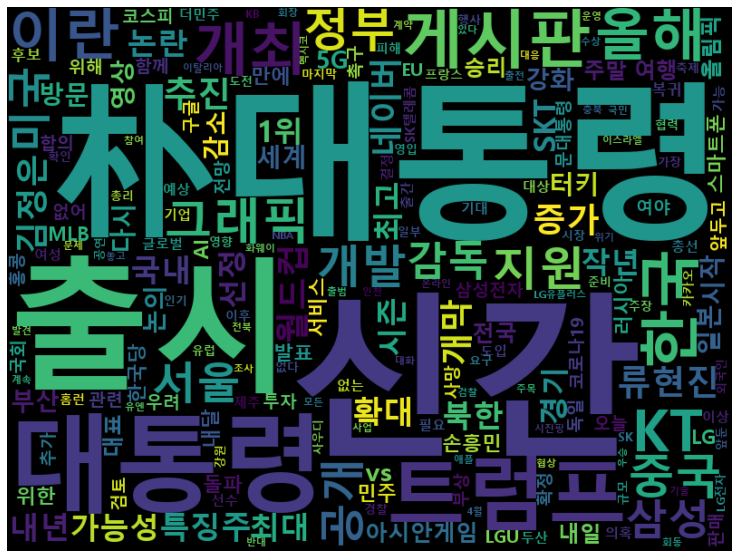

In [ ]:
# wordcloud
# 데이터안에 들어있는 문자열이 아닌 데이터를 모두 제거해야 오류가 안남
train_review = [review for review in train['title'] if type(review) is str]

wordcloud = WordCloud(font_path="/content/drive/MyDrive/etc/"+"malgunbd.ttf", width=800, height=600).generate(' '.join(train_review))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased") # Bert-base의 토크나이저 uncase를 하면 토큰 지정이 안됨
# tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased") # Bert-base의 토크나이저 uncase를 하면 토큰 지정이 안됨

NameError: ignored

Text(0, 0.5, 'Probability')

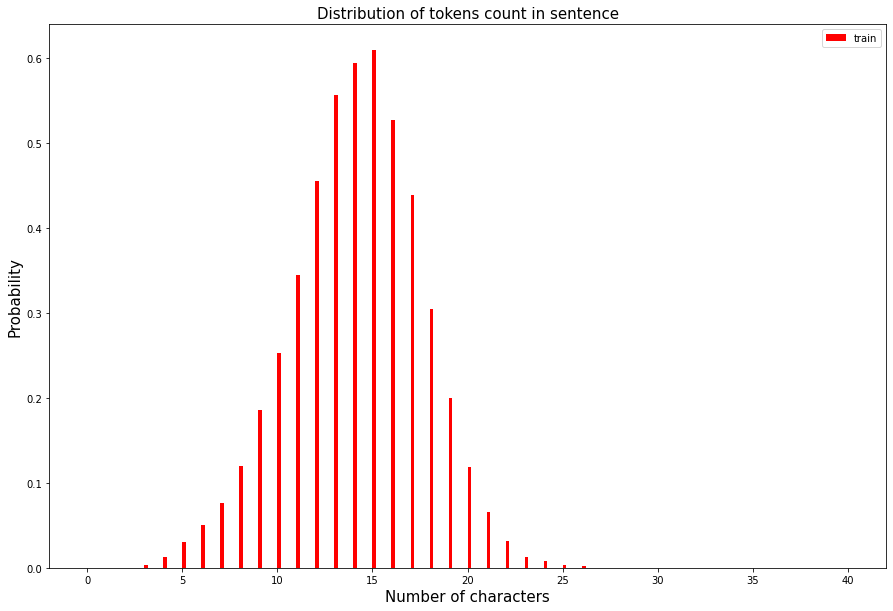

In [ ]:
# 각 문장을 BertTokenizer를 통해 하위 토큰으로 분류한 개수를 분석
train_bert_token_counts = train['title'].apply(lambda x : len(tokenizer.tokenize(x)))

plt.figure(figsize=(15,10))
plt.hist(train_bert_token_counts, bins=200, range=[0,40],density=True, facecolor='r',  label='train')
plt.title('Distribution of tokens count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

In [ ]:
print('문장 tokens 개수 최댓값: {}'.format(np.max(train_bert_token_counts)))
print('문장 tokens 개수 평균값: {:.2f}'.format(np.mean(train_bert_token_counts)))
print('문장 tokens 개수 표준편차: {:.2f}'.format(np.std(train_bert_token_counts)))
print('문장 tokens 개수 중간값: {}'.format(np.median(train_bert_token_counts)))
print('문장 tokens 개수 제 1사분위: {}'.format(np.percentile(train_bert_token_counts, 25)))
print('문장 tokens 개수 제 3사분위: {}'.format(np.percentile(train_bert_token_counts, 75)))
print('문장 tokens 개수 99퍼센트: {}'.format(np.percentile(train_bert_token_counts, 99)))

문장 tokens 개수 최댓값: 28
문장 tokens 개수 평균값: 14.06
문장 tokens 개수 표준편차: 3.41
문장 tokens 개수 중간값: 14.0
문장 tokens 개수 제 1사분위: 12.0
문장 tokens 개수 제 3사분위: 16.0
문장 tokens 개수 99퍼센트: 22.0


{'boxes': [<matplotlib.lines.Line2D at 0x7f44eb7ede50>],
 'caps': [<matplotlib.lines.Line2D at 0x7f44eb7dbed0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f44eb80e450>],
 'means': [<matplotlib.lines.Line2D at 0x7f44eb7dfe90>],
 'medians': [<matplotlib.lines.Line2D at 0x7f44eb7df9d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f44eb7db450>,
  <matplotlib.lines.Line2D at 0x7f44eb7db990>]}

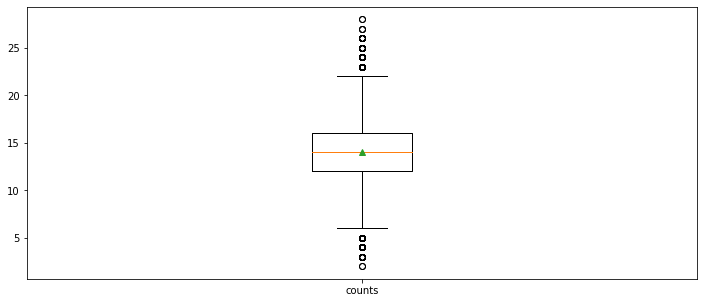

In [ ]:
# 데이터의 길이를 나타내는 Boxplot
plt.figure(figsize=(12, 5))

plt.boxplot(
            train_bert_token_counts, 
            labels=['counts'], 
            showmeans=True
            )

### **불용어 처리**

In [ ]:
# 불용어 리스트
stopwords = []
with open("/content/drive/MyDrive/DACON/topic_classification/stop_words_L.txt") as f:
    for line in f:
        stopwords.append(line.strip())
with open("/content/drive/MyDrive/DACON/topic_classification/stop_words_s.txt") as f:
    for line in f:
        if line not in stopwords:
            stopwords.append(line.strip())
len(set(stopwords))
stopwords = list(set(stopwords))
stopwords

In [ ]:
def hanja_text(sent) : # 불용어 처리를 선택 가능 True로 설정시 불용어처리하겠다는 것 ; 인자값 설정
    
    hanja = re.findall("[一-龥]", sent)

    return hanja

hanja_key = []
for i in train['title']:
    han_ja = hanja_text(i)
    if han_ja:
        hanja_key.extend(han_ja)

hanja_key =list(set(hanja_key))

In [ ]:
hanja_value = [hanja.translate(i, 'substitution') for i in hanja_key] 

hanja_dict = dict(zip(hanja_key, hanja_value))
hanja_dict

In [ ]:
def clean_text(texts):
    corpus = []
    texts = texts.replace("日","일본")
    texts = texts.replace("美","미국")
    texts = texts.replace("北","북한")
    texts = texts.replace("英","영국")
    texts = texts.replace("中","중국")
    texts = texts.replace("與","여당")
    texts = texts.replace("靑","청와대")
    texts = texts.replace("野","야당")
    texts = texts.replace("伊","이탈리아")
    texts = texts.replace("韓","한국")
    texts = texts.replace("南","한국")
    texts = texts.replace("獨","독일")
    texts = texts.replace("佛","프랑스")
    texts = texts.replace("檢","검찰")
    texts = texts.replace("銀","은행")
    for i in range(0, len(texts)):
        
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',str(texts[i])) #remove punctuation
        review = re.sub(r'\d+','', str(texts[i]))# remove number
        review = review.lower() #lower case
        review = re.sub(r'\s+', ' ', review) #remove extra space
        review = re.sub(r'<[^>]+>','',review) #remove Html tags
        review = re.sub(r'\s+', ' ', review) #remove spaces
        review = re.sub(r"^\s+", '', review) #remove space from start
        review = re.sub(r'\s+$', '', review) #remove space from the end
        review = re.sub("[一-龥]",'', review) # remove hanja
        corpus.append(review)
    return corpus

In [ ]:
train_length = train['title'].astype(str).apply(len)
print(train_length.max())
train['title'][:20] 

44


0                      인천→핀란드 항공기 결항…휴가철 여행객 분통
1                실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화
2                이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3              NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합
4                     시진핑 트럼프에 중미 무역협상 조속 타결 희망
5               팔레스타인 가자지구서 16세 소년 이스라엘군 총격에 사망
6                인도 48년 만에 파키스탄 공습…테러 캠프 폭격종합2보
7     美대선 TV토론 음담패설 만회실패 트럼프…사과 대신 빌클린턴 공격해 역효과
8                푸틴 한반도 상황 진전 위한 방안 김정은 위원장과 논의
9              특검 면죄부 받은 트럼프 스캔들 보도 언론 맹공…국민의 적
10                      日 오키나와서 열린 강제징용 노동자 추도식
11               이란서 최고지도자 모욕 혐의 미국인에 징역 10년 선고
12               카니발 축제 보러 가자…브라질 리우에 대형 유람선 행렬
13               美올랜도 병원 최악 총기 테러 부상자 치료비 안 받는다
14                      日 대기업 올해 평균 2.46% 임금 인상
15                    WMO 엘니뇨 여전히 강력…2분기엔 소멸될 듯
16                이스라엘 네타냐후 유대교도 병역문제로 연정 협상 진통
17                UAE 사우디 이어 美 호르무즈 호위 연합에 참여키로
18               사우디군 오만해 유조선 공격 예멘반군과 연결…이란 겨냥
19              개천에서 용 나와라 美사업가 모교에 1천억원 장학금 기부
Name: title, dtype: object

In [ ]:
train.title = clean_text(train.title)
test.title = clean_text(test.title)

In [ ]:
train_data_text = list(train['title'])

train_clear_text = []

for i in tqdm(range(len(train_data_text))):
  train_clear_text.append(str(train_data_text[i]).replace('\\n', ''))
train['clear_title'] = train_clear_text
train.head()

100%|██████████| 45654/45654 [00:00<00:00, 1306604.13it/s]


,index,title,topic_idx,clear_title
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,인천→핀란드 항공기 결항…휴가철 여행객 분통
1,1,실리콘밸리 넘어서겠다…구글 조원 들여 전역 거점화,4,실리콘밸리 넘어서겠다…구글 조원 들여 전역 거점화
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3,3,nyt 클린턴 측근기업 특수관계 조명…공과 사 맞물려종합,4,nyt 클린턴 측근기업 특수관계 조명…공과 사 맞물려종합
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망


In [ ]:
train_clear_text = list(train['clear_title'])

train_clear_text2 = []

for text in train_clear_text:
  temp = re.sub('[-=+,#:;//●<>▲\?:^$.☆!★()Ⅰ@*\"※~>`\'…》→←]', ' ', text)
  train_clear_text2.append(temp)
train['clear_title'] = train_clear_text2
train.head()

,index,title,topic_idx,clear_title
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,인천 핀란드 항공기 결항 휴가철 여행객 분통
1,1,실리콘밸리 넘어서겠다…구글 조원 들여 전역 거점화,4,실리콘밸리 넘어서겠다 구글 조원 들여 전역 거점화
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3,3,nyt 클린턴 측근기업 특수관계 조명…공과 사 맞물려종합,4,nyt 클린턴 측근기업 특수관계 조명 공과 사 맞물려종합
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망


In [ ]:
test_data_text = list(test['title'])

test_clear_text = []

for i in tqdm(range(len(test_data_text))):
  test_clear_text.append(test_data_text[i].replace('\\n', ' '))
test['clear_title'] = test_clear_text
test.head()

100%|██████████| 9131/9131 [00:00<00:00, 1033940.49it/s]


,index,title,clear_title
0,45654,유튜브 내달 일까지 크리에이터 지원 공간 운영,유튜브 내달 일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가rd 평가 때 논문건수는 반영 않는다,내년부터 국가rd 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 권 출간,회색인간 작가 김동식 양심고백 등 새 소설집 권 출간


In [ ]:
test_clear_text = list(test['clear_title'])

test_clear_text2 = []

for text in test_clear_text:
  temp = re.sub('[-=+,#:;//●<>▲\?:^$.☆!★()Ⅰ@*\"※~>`\'…》→←]', ' ', text)
  test_clear_text2.append(temp)
test['clear_title'] = test_clear_text2
test.head()

,index,title,clear_title
0,45654,유튜브 내달 일까지 크리에이터 지원 공간 운영,유튜브 내달 일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사,어버이날 맑다가 흐려져 남부지방 옅은 황사
2,45656,내년부터 국가rd 평가 때 논문건수는 반영 않는다,내년부터 국가rd 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 권 출간,회색인간 작가 김동식 양심고백 등 새 소설집 권 출간


In [ ]:
# trans_hanja_dict = {}  
# sent = sent.replace("日","일본")
# sent = sent.replace("美","미국")
# sent = sent.replace("北","북한")
# sent = sent.replace("英","영국")
# sent = sent.replace("中","중국")
# sent = sent.replace("與","여당")
# sent = sent.replace("靑","청와대")
# sent = sent.replace("野","야당")
# sent = sent.replace("伊","이탈리아")
# sent = sent.replace("韓","한국")
# sent = sent.replace("南","한국")
# sent = sent.replace("獨","독일")
# sent = sent.replace("佛","프랑스")
# sent = sent.replace("檢","검찰")
# sent = sent.replace("銀","은행")

In [ ]:
clear_train_length = train['clear_title'].astype(str).apply(len)
clear_train_length.max()

44

AttributeError: ignored

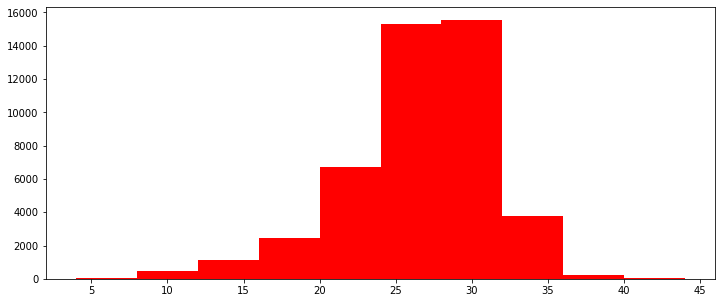

In [ ]:
plt.figure(figsize=(12,5)) # (가로, 세로) 형태의 tuple로 입력
plt.hist(clear_train_length, bin=200, alpha=0.5, color='r',label='word') # alpha 그래프 색상 투명도, label: 그래프 label
plt.yscale('log', nonposy='clip')
plt.title("") #그래프 제목
plt.xlabel("") # x축 label
plt.ylabel("") # x축 label

In [ ]:
 # MAX_LEN 설정시 확인
print('문장 길이 최댓값 : {}'.format(np.max(clear_train_length))) # title길이 최대값
print('문장 길이 최소값 : {}'.format(np.min(clear_train_length))) # title길이 최소값
print('문장 길이 평균값 : {:.2f}'.format(np.mean(clear_train_length))) # title길이 평균값
print('문장 길이 표준편차 : {:.2f}'.format(np.std(clear_train_length))) # title길이 표준편차
print('문장 길이 중간값 : {}'.format(np.median(clear_train_length))) # title길이 중간값
# 사분위의 경우 0~100 스케일 되어있음
print('문장 길이 제1사분위 : {}'.format(np.percentile(clear_train_length, 25))) # title길이 1사분위
print('문장 길이 제3사분위 : {}'.format(np.percentile(clear_train_length, 75))) # title길이 3사분위

문장 길이 최댓값 : 44
문장 길이 최소값 : 4
문장 길이 평균값 : 26.11
문장 길이 표준편차 : 4.74
문장 길이 중간값 : 27.0
문장 길이 제1사분위 : 24.0
문장 길이 제3사분위 : 29.0


In [ ]:
qmarks = np.mean(train['clear_title'].apply(lambda x: '?' in x)) # ?가 구두점으로 쓰임
fullstop = np.mean(train['clear_title'].apply(lambda x: '.' in x)) # 마침표
capital_first = np.mean(train['clear_title'].apply(lambda x: x[0].isupper() )) # 첫번째 대문자
capitals = np.mean(train['clear_title'].apply(lambda x: max([y.isupper() for y in x]))) # 대문자 개수
numbers = np.mean(train['clear_title'].apply(lambda x: max([y.isdigit() for y in x]))) # 숫자 개수

# 전처리 과정에서 대문자인 경우 모두 소문자로 바꾸고 특수문자는 모두 제거
#
print('물음표가 있는 title: {:.2f}%'.format(qmarks * 100) ) 
print('마침표가 있는 title: {:.2f}%'.format(fullstop * 100) ) 
print('첫 글자가 대문자인 title: {:.2f}%'.format(capital_first * 100) ) 
print('대문자가 있는 title: {:.2f}%'.format(capitals * 100) ) 
print('숫자가 있는 title: {:.2f}%'.format(numbers * 100) )         

물음표가 있는 title: 0.00%
마침표가 있는 title: 0.00%
첫 글자가 대문자인 title: 0.00%
대문자가 있는 title: 0.00%
숫자가 있는 title: 0.31%


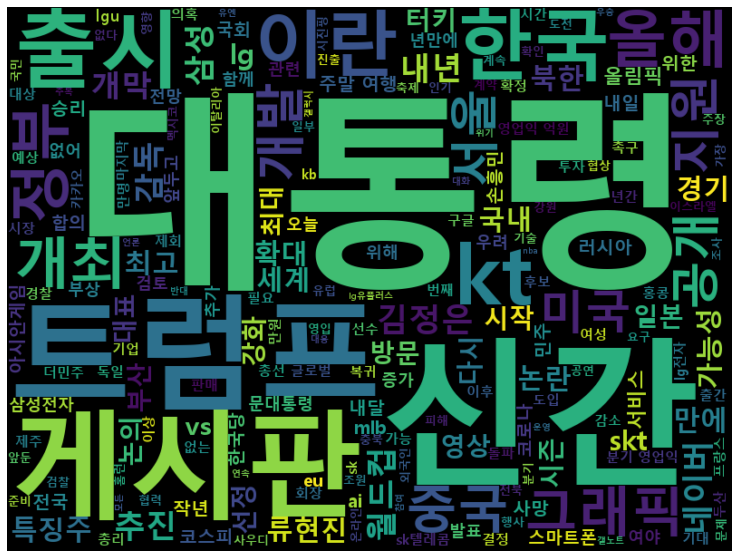

In [ ]:
# wordcloud
# 데이터안에 들어있는 문자열이 아닌 데이터를 모두 제거해야 오류가 안남
train_review = [review for review in train['clear_title'] if type(review) is str]

wordcloud = WordCloud(font_path="/content/drive/MyDrive/etc/"+"malgunbd.ttf", width=800, height=600).generate(' '.join(train_review))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Text(0, 0.5, 'Probability')

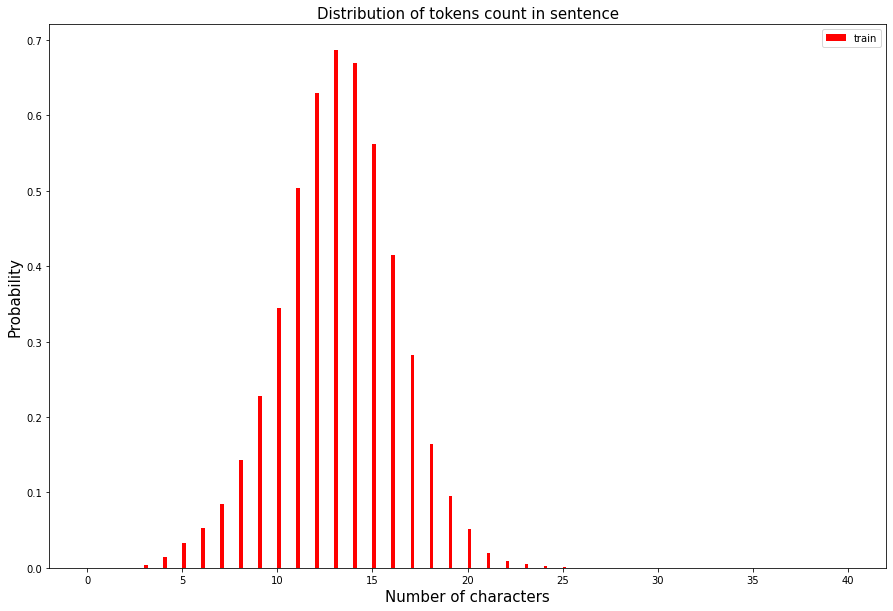

In [ ]:
# 각 문장을 BertTokenizer를 통해 하위 토큰으로 분류한 개수를 분석
train_bert_token_counts = train['clear_title'].apply(lambda x : len(tokenizer.tokenize(x)))

plt.figure(figsize=(15,10))
plt.hist(train_bert_token_counts, bins=200, range=[0,40],density=True, facecolor='r',  label='train')
plt.title('Distribution of tokens count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

In [ ]:
print('문장 tokens 개수 최댓값: {}'.format(np.max(train_bert_token_counts)))
print('문장 tokens 개수 평균값: {:.2f}'.format(np.mean(train_bert_token_counts)))
print('문장 tokens 개수 표준편차: {:.2f}'.format(np.std(train_bert_token_counts)))
print('문장 tokens 개수 중간값: {}'.format(np.median(train_bert_token_counts)))
print('문장 tokens 개수 제 1사분위: {}'.format(np.percentile(train_bert_token_counts, 25)))
print('문장 tokens 개수 제 3사분위: {}'.format(np.percentile(train_bert_token_counts, 75)))
print('문장 tokens 개수 99퍼센트: {}'.format(np.percentile(train_bert_token_counts, 99)))

문장 tokens 개수 최댓값: 27
문장 tokens 개수 평균값: 13.13
문장 tokens 개수 표준편차: 3.05
문장 tokens 개수 중간값: 13.0
문장 tokens 개수 제 1사분위: 11.0
문장 tokens 개수 제 3사분위: 15.0
문장 tokens 개수 99퍼센트: 20.0


{'boxes': [<matplotlib.lines.Line2D at 0x7f44eb838cd0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f44eb831090>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f44eb8285d0>],
 'means': [<matplotlib.lines.Line2D at 0x7f44eb828090>],
 'medians': [<matplotlib.lines.Line2D at 0x7f44eb828050>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f44eb797390>,
  <matplotlib.lines.Line2D at 0x7f44eb831050>]}

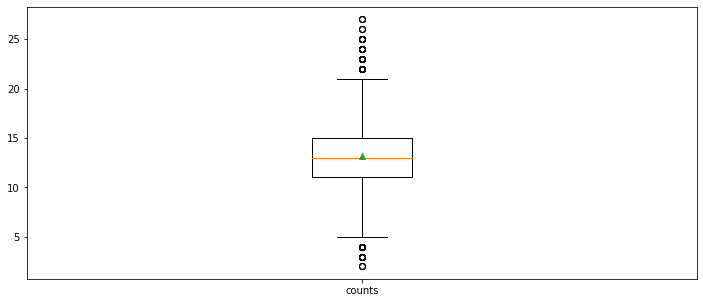

In [ ]:
# 데이터의 길이를 나타내는 Boxplot
plt.figure(figsize=(12, 5))

plt.boxplot(
            train_bert_token_counts, 
            labels=['counts'], 
            showmeans=True
            )

In [ ]:
train['clear_title']

0               인천 핀란드 항공기 결항 휴가철 여행객 분통
1            실리콘밸리 넘어서겠다 구글 조원 들여 전역 거점화
2         이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3        nyt 클린턴 측근기업 특수관계 조명 공과 사 맞물려종합
4              시진핑 트럼프에 중미 무역협상 조속 타결 희망
                      ...               
45649       kb금융 미국 ib 스티펠과 제휴 선진국 시장 공략
45650     보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토
45651             게시판 키움증권 키움 영웅전 실전투자대회
45652                  답변하는 배기동 국립중앙박물관장
45653       한국인터넷기자상 시상식 내달 일 개최 특별상 김성후
Name: clear_title, Length: 45654, dtype: object

# BERT 모델 구성

In [ ]:
model_name = 'bert-base-multilingual-cased'
SEED_NUM = 977
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)
BATCH_SIZE = 150
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 30
NUM_CLASS = 7
K_SPLIT = 3
# 이상치 데이터로인해 평균이 급격히 올라갈수 있기에 EDA분석을 통해 적절히 정해야함 평균값이던 중간값이던 3사분위 값이던
# EDA를 통해 이상치 데이터가 없으면 최대값이용

In [ ]:


# BERT에 필요한 입력값은 총 3개
# input_ids : 문장을 tokenize해서 index로 변환
# attention_mask : 1은 attention에 영향을 받음, 0은 영향을 받지 않음
# token_type_ids : 0과 1로 문장의 토큰 값을 분리

# special token 역할
# [UNK] : 모르는 단어에 대한 token
# [MASK] : 마스크 token, 사전학습(Pre-training)에서 활용
# [PAD] : 최대 길이를 맞추는 용도
# [SEP] : 문장의 종결을 알림
# [CLS] : 문장의 시작을 알림

def bert_tokenizer(sent, MAX_LEN):

    encoded_dict = tokenizer.encode_plus(
        
        text = sent,
        add_special_tokens = True, # True : 토큰 시작점에 [CLS] 토큰과 토큰의 마지막에 [SEP]토큰을 붙임
        max_length = MAX_LEN, # MAX_LEN 최대 길이에 따라 문장의 길이를 맞추는 작업을 진행 ; MAX_LEN보다 길면 truncate
        pad_to_max_length = True, # True : MAX_LEN의 길이에 미치지 못하는 문장에 padding을 적용 **padding : 길이를 일괄적으로 맞춰주는 것
                                                     # 각 데이터의 길이가 다를경우 모델에 적용할 수 없음 그렇기에 padding진행
                                         
        return_attention_mask = True, # True : BERT에 필요한 입력값 중 attention_mask를 생성
        truncation = True 
        # encoded_plus 과정 중 token_type으로 문장이 1개면 0, 문장이 2개면 0과 1로 구분
    )


    input_id = encoded_dict['input_ids'] # BERT 입력값 중 하나인 input_ids
    attention_mask = encoded_dict['attention_mask'] # attention_mask ; 단순히 padding과 non-padding을 구분
    token_type_id = encoded_dict['token_type_ids'] # 두개의 문장 구분용


    return input_id, attention_mask, token_type_id # 각각의 BERT 입력값들을 encoded_dict를 한 결과를 return

In [ ]:
print(tokenizer.all_special_tokens) # BERT special tokens
print(tokenizer.all_special_ids)  # BERT special tokens의 index

['<s>', '</s>', '<unk>', '<pad>']
[0, 1, 5, 3]


In [ ]:
# kfold = KFold(n_splits=K_SPLIT, shuffle=True, random_state=SEED_NUM)

# for train_index, val_index in kf.split(train_news_inputs, train_data_labels):
# tokeniner로 encoding하는 것을 함수로 선언하기


input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

# bert_tokenizer를 이용하여 encoding진행
for train_sent, train_label in tqdm(zip(train["clear_title"], train["topic_idx"])): 
    try:

        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)
        
    except Exception as e:
        print(e)
        print(train_sent)
        pass


train_news_input_ids = np.array(input_ids, dtype=int)
train_news_attention_masks = np.array(attention_masks, dtype=int)
train_news_type_ids = np.array(token_type_ids, dtype=int)

# 최종 출력값은 numpy로 변환한 후 tuple 형태로 묶어서 저장
train_news_inputs = (train_news_input_ids, train_news_attention_masks, train_news_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) # 정답 tokenizing 리스트


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
45654it [00:04, 10060.94it/s]


In [ ]:
# bert_tokenizer를 통해 실제결과가 나오는지 테스트
INPUT_id = train_news_input_ids[30]
ATTENTION_mask = train_news_attention_masks[30]
TOKEN_TYPE_id = train_news_type_ids[30]

print(INPUT_id)
print(ATTENTION_mask)
print(TOKEN_TYPE_id)
print(tokenizer.decode(INPUT_id))

[21376 12034 13090 14255 10500 22911   301   298 16429 20955 14941 14099
 13791 14518 16777 14931 17471  1700  1700  1700     3     3     3     3
     3     3     3     3     3     3]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
셰이크 살만 afc 회장 평양 방문 최휘 국가체육지도위원장   <pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


## 1. bert_tokenizer로 encoding된 data를 활용해 학습 진행
### * bert 분류 class 구성하고 최적화, 손실값, 정확도 선언

In [ ]:
class TFBertClassifier(tf.keras.Model): # pre_trained된 bert model을 불러와 그 위에 완전연결층 1층을 쌓은 구조
                                                              # class로 모델을 구현하려면 tf.keras.Model을 상속받아야 함
    # TFBertClassifier생성할 때마다 __init__실행                                                          
    def __init__(self, model_name, dir_path, num_class): # model_name : 인자로 받아 활용할 모델 이름, dir_path : 모델이 저장된 위치
                                                                                            # num_class : 원하는 정답의 개수(감성분석인 경우 2; 긍정, 부정)
        # super함수를 통해 부모 클래스(tf.keras.Model)에 있는 __init__함수 호출   
        # tf.keras.Model 클래스를 상속받는 경우 super함수를 통해 부모 클래스에 __init__ 함수의 인자에 모델이름을 전달하면
        # tf.keras.Model을 상속받은 모든 자식은 해당 모델의 이름으로 공통적으로 사용
        super(TFBertClassifier, self).__init__()

         
        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path) # 기존에 pre_trained 한 부분이 로드됨
                                                                                                                                    
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob) # 과적합을 방지하기 위한 layer
        # self.classifier을 통해 topic_idx를 전부 분류
        self.classifier = tf.keras.layers.Dense(num_class,
                                                                    kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                                    name="classifier")  # 완전연결층 1층


    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False): 
        #__init__에서 선언한 내용을 실제 입력을 받고 실행하는 call 메서드임
        # call함수를 호출하면 입력한 inputs을 통해 마지막에 예측값을 출력
        # 영화 리뷰 text를 inputs을 통해 받음
        

        # output 값 : sequence_output, pooled_output, (hidden_states), (attentions)
        # sequence_output : sequence 길이의 출력을 모두 입력으로 받음; 이 벡터의 차원 ' 임베딩 크기 * 최대문장길이'
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids) # bert를 통해 outputs로 결과값을 추출
        pooled_output = outputs[1] # pooled_output
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output) # self.classifier를 통해 완전연결층을 활용하여 최종적으로 self.num_labels 개수에 맞는 예측값을 출력

        return logits

cls_model = TFBertClassifier(model_name=model_name,
                                                dir_path='bert_ckpt', # ???
                                                num_class=NUM_CLASS) # num_class 바꿔야함



AttributeError: ignored

### Adam최적화와 손실값, 모델 정확도 정의

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

cls_model.compile(optimizer=optimizer,
                                loss=loss,
                                metrics=[metric])

In [ ]:
# 모델이 어느 시점이 되면 학습평가점수는 높아지는데 검증평가 점수가 낮아지는 overfitting현상이 발생하거나
# 학습도중 특정 상태의 모델에서 하이퍼파라미터를 바꿔서 다시 학습을 진행할 수도 있음
# => tensowflow.keras.callback 모듈의 EarlyStopping, ModelCheckpoint 클래스를 활용하여 해결


# 특정 epoch에서 현재 검증 평가 점수가 이전 검증 평가 점수보다 일정수치 미만으로 낮아지면 학습을 멈추는 역할
# 학습 중 overfitting을 방지한다는 것
earlystop_callback = EarlyStopping(monitor='val_accuracy', # 'val_accuracy'를 통해 검증 평가 점수로 활용한다는 것
                                                        min_delta=0.0001, # 활용한 평가 점수에 따라 현재 점수가 이전 점수에 비해 0.0001 보다 낮아지면 overfitting현상이 발생한다고 생각하고 학습을 멈춤
                                                        patience=2) # 검증 평가 점수가 이전 최고 점수보다 높아지지 않는 epoch수가 patience에 입력한 횟수를 넘어가면 학습을 멈춤

# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)



DATA_OUT_PATH = '/content/drive/MyDrive/bert_data_out'
# 오류시 DATA_OUT_PATH = '/content/gdrive/MyDrive/bert_data_out'

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

# Epoch마다 모델을 저장하게끔 함(학습중 모델을 저장한다는 것)    
cp_callback = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_accuracy', # save_best_only를 하는 평가기준
    verbose=1, 
    save_best_only=True, # True : 가장 성능이 좋은 모델만 저장한다는 것
    save_weights_only=True # True : 모델 그래프를 전부 저장하는 것이 아닌 모델 가중치만 저장한다는 것
    )


/content/drive/MyDrive/bert_data_outbert-base-multilingual-cased -- Folder create complete 



In [ ]:

# 학습과 eval 시작
history = cls_model.fit(train_news_inputs, train_data_labels, 
                        epochs=NUM_EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_split = VALID_SPLIT, # 학습데이터에서 일정한 비율로 무작위로 나눔
                        # callbacks=[earlystop_callback, cp_callback]
                        ) # 검증데이터셋이 있을경우 파라미터로 validation_data = 로 데이터셋을 지정한 다음 validation_split파라미터를 지운다.

Epoch 1/3


ValueError: ignored

## 모델 Test

In [ ]:


input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

# bert_tokenizer를 이용하여 encoding진행
for test_sent in test["clear_title"]: 
    try:

        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        
    except Exception as e:
        print(e)
        print(test_sent)
        pass


test_news_input_ids = np.array(input_ids, dtype=int)
test_news_attention_masks = np.array(attention_masks, dtype=int)
test_news_type_ids = np.array(token_type_ids, dtype=int)

test_news_inputs = (test_news_input_ids, test_news_attention_masks, test_news_type_ids)




/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# cls_model.load_weights(os.path.join('/content/drive/MyDrive/bert_data_outbert-base-multilingual-cased', 'weights.h5')) # 오류시 '/weight.h5'

predictions = cls_model.predict(test_news_inputs)



In [ ]:
submission

,index,topic_idx
0,45654,0
1,45655,0
2,45656,0
3,45657,0
4,45658,0
...,...,...
9126,54780,0
9127,54781,0
9128,54782,0
9129,54783,0


In [ ]:
predictions

array([[ 3.6135612 ,  1.3706089 ,  0.26720187, ..., -2.2385573 ,
        -3.1308568 , -3.6032915 ],
       [-2.6554773 , -2.48627   , -0.8125231 , ..., -1.0231861 ,
        -0.7027764 ,  0.8098614 ],
       [ 1.1466565 , -2.805643  ,  4.1818857 , ..., -1.7698392 ,
        -1.2361221 , -0.2596517 ],
       ...,
       [-4.550177  , -3.4584873 ,  3.3846695 , ...,  0.68750185,
        -2.2466998 ,  1.7887033 ],
       [-1.9593185 ,  3.4477787 ,  4.4681597 , ..., -0.3710351 ,
        -2.873817  , -2.610401  ],
       [-2.4470656 , -1.517249  ,  6.076943  , ..., -2.5806334 ,
        -2.1862724 ,  4.4734163 ]], dtype=float32)

In [ ]:
pred = np.argmax(predictions, axis = 1)
submission.topic_idx = pred
submission.sample(3)

#submission.to_csv(path, index = False)

,index,topic_idx
6885,52539,4
7356,53010,1
656,46310,4


In [ ]:
submission

,index,topic_idx
0,45654,0
1,45655,3
2,45656,2
3,45657,2
4,45658,3
...,...,...
9126,54780,3
9127,54781,4
9128,54782,3
9129,54783,2


In [ ]:
submission.to_csv('bert_baseline.csv',index = False)
# submission.to_csv('bert_baseline_1.csv',index = True)

In [ ]:
print(history.history)

{'loss': [0.7074391841888428, 0.4402851462364197, 0.3594503104686737, 0.29631200432777405, 0.24131686985492706, 0.19897915422916412, 0.1633981466293335], 'accuracy': [0.7605071067810059, 0.8519289493560791, 0.8769816160202026, 0.8973797559738159, 0.9168195128440857, 0.9296607375144958, 0.9425840973854065], 'val_loss': [0.6750518679618835, 0.618735134601593, 0.6169738173484802, 0.6421561241149902, 0.6430529356002808, 0.7034903168678284, 0.7511146664619446], 'val_accuracy': [0.75599604845047, 0.7812944650650024, 0.7889606952667236, 0.7833753228187561, 0.8006790280342102, 0.793012797832489, 0.7873179316520691]}


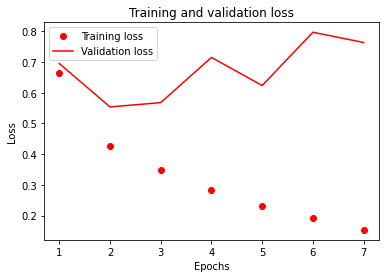

In [ ]:


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

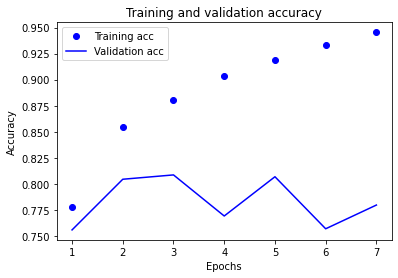

In [ ]:
plt.clf()   # 초기화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
!pip install dacon_submit_api-0.0.4-py3-none-any.whl

Processing ./dacon_submit_api-0.0.4-py3-none-any.whl


In [ ]:
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
'/content/bert_baseline.csv', # 파일경로
'963c7ac10aaec9291841f0e9637c83a987736c9e4133f752538a63532fdd1d64',  # 개인토큰
'235747', # 대회 id
'Healthy Guys',  # 팀이름
'bert') # 노트

{'isSubmitted': True, 'detail': 'Success'}
